# Практическое ДЗ-2. Использование ALS для построения рекомендательной модели

В этой задаче мы построим простую рекомендательную модель на основе малоранговых приближений разреженных матриц.

In [4]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
%matplotlib inline

### Подготовка датасета
Загрузите датасет movielens10m с [grouplens.org](https://grouplens.org/datasets/movielens/10m/) или [disk.yandex.ru](https://disk.yandex.ru/d/HIjLehGZEcCRig) и положите архив в папку `data`. Нас будет интересовать файл `ratings.dat`, в котором собраны оценки пользователями различных фильмов с сервиса movielens.org. Вытащим этот файл из архива. Как можно узнать из соответствующей [странички](http://files.grouplens.org/datasets/movielens/ml-10m-README.html#file_desc), этот файл имеет формат `UserID::MovieID::Rating::Timestamp`. Сразу позаботимся, чтобы id пользователей и фильмов начинались с нуля (в самом файле индексация с единицы).

In [5]:
!mkdir data

In [6]:
!wget --trust-server-names https://files.grouplens.org/datasets/movielens/ml-10m.zip

--2024-03-19 16:25:41--  https://files.grouplens.org/datasets/movielens/ml-10m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65566137 (63M) [application/zip]
Saving to: ‘ml-10m.zip’

ml-10m.zip          100%[===================>]  62.53M  14.0MB/s    in 6.0s    

2024-03-19 16:25:49 (10.5 MB/s) - ‘ml-10m.zip’ saved [65566137/65566137]



In [7]:
!mv ml-10m.zip data

In [8]:
import zipfile
user_ids = []
movie_ids = []
ratings = []
with zipfile.ZipFile('data/ml-10m.zip') as archive:
    with archive.open('ml-10M100K/ratings.dat') as f:
        for l in f:
            user, movie, rating, _ = l.split(b'::')
            user_ids.append(int(user) - 1)
            movie_ids.append(int(movie) - 1)
            ratings.append(float(rating))

Составим матрицу рейтингов $A \in \mathbb R^{m \times n}$, индексируемую номером пользователем и номером фильма.
Для простоты мы будем делить отзывы только на положительные (`Rating >= 4` &mdash; $A_{i,j}=1$) и отрицательные (`Rating < 4` &mdash; $A_{i,j} = 0$), таким образом, матрица у нас получится состоящей только из нулей и единиц.
Обратите внимание, что матрица будет разреженной, так как средний пользователь оценил относительно мало фильмов. Поэтому мы будем пользоваться библиотекой `scipy.sparse`. Хранить матрицу мы будем в формате хранения разреженных матриц [CSR](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)), который поддерживает матричное умножение на numpy массивы: ```A @ X ```.

In [9]:
from scipy.sparse import csr_matrix
A = csr_matrix((np.array(ratings) >= 4, (user_ids, movie_ids)), dtype=np.float32)
A.eliminate_zeros()
print("Shape:", A.shape)
print("Ratio of nonzero elements:", A.nnz / (A.shape[0] * A.shape[1]))

Shape: (71567, 65133)
Ratio of nonzero elements: 0.0010738646228571796


Отделим некоторое количество пользователей для последующей проверки. Используем стандартное разбиение train/test 80/20.

In [10]:
n_users, n_movies = A.shape
n_test = int(n_users * 0.2)
n_train = n_users - n_test
idx = np.arange(n_users)
np.random.shuffle(idx)
test_idx, train_idx = idx[:n_test], idx[n_test:]
A_test, A_train = A[test_idx,:], A[train_idx,:]

Далее в задаче мы будем строить рекомендации пользователям на основе малорангового приближения матрицы $A$ (матрицы $A_{train}$ в рамках обозначений выше).
Обратим внимание, что из-за ограничений по памяти мы не можем сформировать матрицу $A$ в виде numpy массива, а значит теряем доступ к ```np.linalg.svd```. Поэтому мы будем реализовывать метод ALS, в котором требуется только умножение на матрицы $A$ и $A^\top$, что поддерживается разреженными форматами хранения матриц (CSR, COO и тд).

### a. (35 баллов) Вычисление вспомогательных функционалов

  1. **(15 баллов)** Напомним, что в методе ALS решается задача минимизации функционала $f(U, V^\top) = \|A - UV^\top\|_F$ по всем $U \in \mathbb R^{m \times r}$ и $V  \in \mathbb R^{n \times r}$. Первым делом вам нужно будет написать функцию `als_functional` для вычисления оптимизируемого функционала $\|A - UV^\top\|_F$ для заданных $A$, $U$, $V^\top$. Заметьте, что прямое вычисление этой нормы &mdash; очень трудоёмкая задача, ведь разность будет плотной матрицей. Для того, чтобы эффективно вычислить норму разности, распишите $\|A - UV^\top\|_F^2$ через скалярное произведение $\langle X,Y \rangle_F = \mathrm{Tr}\,(X^\top Y)$, выполните алгебраические преобразования и покажите, как эффективно вычислить каждый член в полученном выражении. Для начала выведите необходимые формулы аналитически, а затем реализуйте их в коде. Ни на каком этапе вы не должны явно формировать плотные матрицы размеров `A.shape` (хотя numpy, скорее всего, и откажется аллоцировать 37 ГБ под такой массив).
  
  **Замечание**: не используйте циклы по ненулевым элементам разреженной матрицы $A$. Убедитесь, что в ваши формулы входит только умножение на матрицы $A$ или $A^\top$, на которые можно умножать посредством @; либо умножения сложности $O(mr^2), O(nr^2)$. Также отметим, что норма матрицы $A$ уже дана, заново её вычислять не надо.  Везде считайте $r < m, n$.

**Сделаем ряд  преобразований:**

$$\|A - UV^T\|^2_F \ = \ Tr((A - UV^T)^T \times (A - UV^T)) \ = \ Tr((A^T - U^TV) \times (A - UV^T)) \ = \ Tr(A^TA - A^TUV^T - VU^TA + VU^TUV^T) \ = \ \|A\|^2_F - Tr(A^TUV^T + VU^TA) + Tr(VU^TUV^T) = \ \|A\|^2_F - 2 \times Tr(A^TUV^T) + Tr(VU^TUV^T)$$

In [11]:
def als_functional(A, A_norm, U, VT):
    """
        Input
            A: sparse 2D array
            A_norm: Frobenius norm of A
            U, VT: 2D arrays such that U @ VT approximates A
        Output
            ||A - U VT||_F
    """
    return np.sqrt(A_norm ** 2 - 2 * np.trace(VT @ A.T @ U) + np.trace((VT @ VT.T) @ (U.T @ U)))

**Замечание:** Если вы не сможете выполнить следующие два пункта, можете их пропустить. Они не являются обязательными для следующих заданий.

  2. **(10 баллов)** *Расстоянием от подпространства* $L_1 \subset \mathbb{R}^m$ *до подпространства* $L_2 \subset \mathbb{R}^m$ будем называть число $\|(I - P(L_1)) P(L_2)\|_2$, где $P(L_i)$ &mdash; ортопроектор на $L_i$. Функция несимметричная, так что будьте осторожны с расстановкой аргументов. Опишите алгоритм вычисления расстояния от $\mathrm{Im}(U_1)$ до $\mathrm{Im}(U_2)$ для заданных матриц $U_1, U_2 \in \mathbb{R}^{m \times r}$ с ортонормированными столбцами (т.е. $U_i^\top U_i = I$). Алгоритм должен иметь сложность $O(mr^2)$. **Подсказка.** Воспользуйтесь техникой малоранговой арифметики, описанной на соответствующих лекции и семинаре.

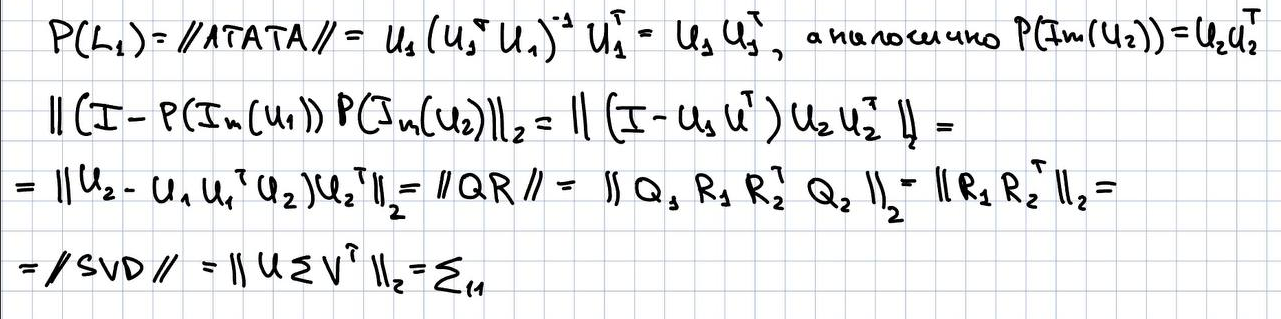



Оценим сложность:
QR для $m \times 2r$ + SVD для матрицы $r \times r \sim O(mr^2 + r^3) = O(mr^2)$




  3. **(10 баллов)** Напишите функцию `dist_between_subspaces`, принимающую на вход матрицы $U_1, U_2 \in \mathbb{R}^{m\times r}$ с ортонормированными столбцами, и возвращающую расстояние от $\mathrm{Im}(U_1)$ до $\mathrm{Im}(U_2)$. Сложность алгоритма должна быть $O(mr^2)$.

In [12]:
def dist_between_subspaces(U1, U2):
    """
        Input
            U1, U2: matrices with orthonormal columns
        Output
            Distance from Im(U1) to Im(U2)
    """

    _, R_1 = np.linalg.qr(U2 - U1 @ (U1.T @ U2), axis=1)
    _, R_2 = np.linalg.qr(U2, axis=1)

    _, S, _ = np.linalg.svd(R_1 @ R_2.T, full_matrices=False)
    return S[0]

### b. (30 баллов) Метод ALS
Реализуйте метод ALS (alternating least squares) с ортогонализацией (см. лекции).

Вам будет необходимо вернуть две матрицы: $U$ и $V^\top$, образующие скелетное разложение результирующего приближения; где $U$ имеет ортонормированные столбцы. Также нужно вернуть 3 списка:


*   Список значений функционала $f(U_k, V^\top_k) = \|A - U_k V^\top_k\|_F$

*   Список изменений значений функционала $\delta_k = f(U_{k-1}, V^\top_{k-1}) - f(U_k, V^\top_k)$

*   Список растояний между пространствами $\|(I - P(U_{k-1}))P(U_{k})\|_2$

В качестве критерия остановки будем использовать величину $\delta_k$. При значении $\delta_k \le tolerance$ алгоритм должен остановиться. При указании `debug=True` печатайте номер текущей итерации и последнюю $\delta_k$, а также любую дополнительную интересную вам информацию.

Используйте реализованные выше функции. Для вычисления фробениусовой нормы разреженной матрицы используйте `norm` из `scipy.sparse.linalg`.

**Замечание:** Если вы не реализовали dist_between_subspaces, то вместо третьего списка возращайте None.

In [49]:
from scipy.sparse.linalg import norm as sparse_norm

def ALS(A, rank, tolerance=1e-2, debug=False):
    """
        Input
            A: 2D m x n numpy array
            rank: required rank of the approximation
            tolerance: stop when delta_k is less or equal to it
            debug: print debug information on each iteration

        Output
            U, VT: m x rank, rank x n numpy arrays forming skeleton decomposition;
                   columns of matrix U are orthonormal
            fs: list of f(U_k, VT_k)
            deltas: list of f(U_{k-1}, VT_{k-1}) - f(U_k, VT_k)
            dists: list of distances from Im(U_{k-1}) and Im(U_k)
    """
    norm = sparse_norm(A)
    fs = []
    deltas = []
    dists = []
    U_k = np.random.randn(A.shape[0], rank)
    U_k, _ = np.linalg.qr(U_k)
    V_k = np.random.randn(A.shape[1], rank)
    V_k, _ = np.linalg.qr(V_k)
    fs.append(als_functional(A, norm, U_k, V_k.T))

    iter = 0
    delta = 0
    while True:
      U_k1 = U_k
      V_k1 = V_k

      V_k, R = np.linalg.qr(A.T @ U_k1)
      U_k, R = np.linalg.qr(A @ V_k)
      V_k = V_k @ R.T
      dists.append(dist_between_subspaces(U_k1, U_k))
      fs.append(als_functional(A, norm, U_k, V_k.T))
      delta = fs[-2] - fs[-1]
      deltas.append(delta)
      if debug:
        print(f'Iteration {iter}, Delta_k value is {deltas[-1]}')

      iter += 1
      if (tolerance >= delta):
        break

    return U_k, V_k.T, fs, deltas, dists


Запустим метод на матрице `A_train` и посмотрим на убывание функционала от номера итерации.

Iteration 0, Delta_k value is 196.48036970518683
Iteration 1, Delta_k value is 143.45480911441746
Iteration 2, Delta_k value is 15.318067230309225
Iteration 3, Delta_k value is 4.113835488855102
Iteration 4, Delta_k value is 1.6449149660795683
Iteration 5, Delta_k value is 0.8323304960986206
Iteration 6, Delta_k value is 0.4854891751010655
Iteration 7, Delta_k value is 0.3072361931785963
Iteration 8, Delta_k value is 0.2047352630070236
Iteration 9, Delta_k value is 0.14223625246449956
Iteration 10, Delta_k value is 0.1026109066835943
Iteration 11, Delta_k value is 0.07653853406554845


[]

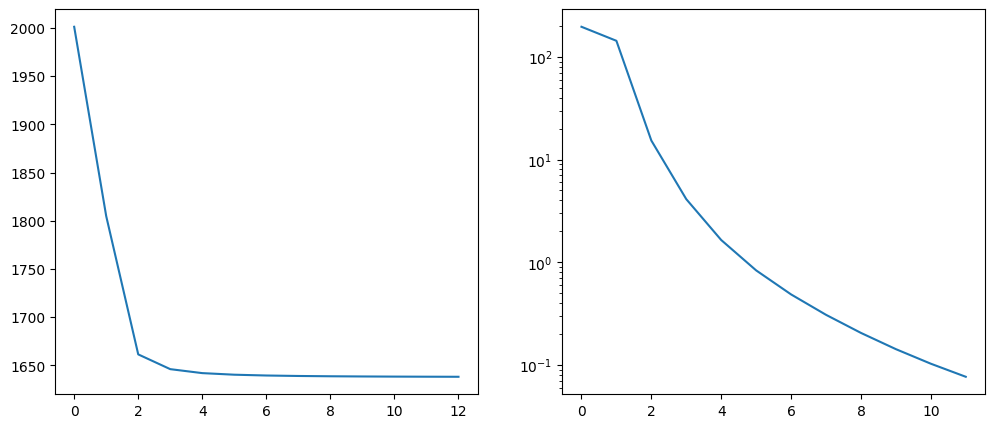

In [50]:
rank = 30
U_als, VT_als, fs, deltas, dists = ALS(A_train, rank, 0.1, debug=True)

fig, axs = plt.subplots(figsize=(12, 5), ncols=2)

axs[0].plot(fs)
axs[1].plot(deltas)
axs[1].semilogy()

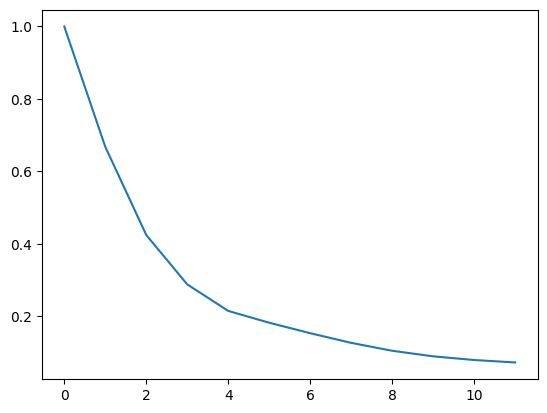

In [51]:
# опционально

plt.plot(dists)

### c. (10 баллов) Сравнение с рандомизированным SVD и разреженным SVD

Примените рандомизированное SVD из sklearn, а также SVD из scipy, поддерживающее разреженные матрицы (используйте тот же ранг 30, что и для ALS). Сравните все три результата по значению функционала.

In [52]:
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

A_norm = sparse_norm(A_train)

print(f"ALS functional: {als_functional(A_train, A_norm, U_als, VT_als)}")
U, Sigma, VT = randomized_svd(A_train, n_components=30)
print(f'randomized SVD functional: {als_functional(A_train, A_norm, U @ np.diag(Sigma), VT)}')
U, Sigma, VT = svds(A_train, k=30)
print(f'svds functional: {als_functional(A_train, A_norm, U @ np.diag(Sigma), VT)}')

ALS functional: 1638.108618422639
randomized SVD functional: 1637.9305055177786
svds functional: 1637.7423762319047


Получили, по сути, одно и то же... хотя наш алгоритм и дал НемНоЖко больший функционал

### d. (25 баллов) Построение рекомендаций
  1. **(10 баллов)** Научимся рекомендовать пользователям из тестовой группы фильмы на основе части их оценок. Напишем функцию `recommend`, которая будет принимать матрицу $V$ из нашей модели, матрицу `(user_id, movie_id) -> binary rating` (то есть того же формата, что и наша основная матрица `A`), а также число `pred_am` &mdash; количество фильмов, которые мы хотим порекомендовать. Возвращать функция будет top-`pred_am` рекомендаций, то есть `pred_am` фильмов, которые могут пользователю понравиться, в порядке убывания предсказанной привлекательности.

  Чтобы построить рекомендацию, необходимо ортогонально спроецировать вектор, соответствующий новому пользователю (про которого мы знаем часть оценок), на пространство $L$, образуемое строками матрицы $V^\top$. Иными словами, мы должны взять ближайший вектор из $L$. Он будет содержать предсказанные нашей моделью рейтинги. Дальше дело техники :) Но не забудьте, что `score_mat` содержит векторы, соответствующие не одному пользователю, а батчу из `batch_size` пользователей. Хотя и (слава numpy) код остаётся почти дословно такой же. **Подсказка:** используйте функцию `np.argsort`.

In [27]:
def recommend(score_mat, pred_am, V):
    """
        Input
            score_mat: sparse batch_size x n_movies array
            pred_am: requested number of recommendations
            V: 2D numpy array

        Output
            recs: batch_size x pred_am array of movies to recommend, with descending predicted rating
    """
    Q, R = np.linalg.qr(VT.T)
    recs = (Q @ (Q.T @ score_mat.T)).T
    return np.argsort(recs)[:, ::-1][:, :pred_am]

Для проверки нашей модели для каждого пользователя из тестовой выборки оценим так называемый **hit rate**. Для этого выбросим одну из его оценок, вызовем функцию `recommend` и посмотрим, попал ли выкинутый фильм в подборку. Если попал &mdash; это hit, иначе не hit. Для того, чтобы эффективно проделать этот эксперимент на всех тестовых данных, сделаем следующее: разобьём тестовую матрицу на батчи по 500 пользователей и будем предсказывать сразу для целого батча. Вычислим вектор размера `n_test`, где для каждого пользователя указано, на каком месте в рекомендованной подборке оказался скрытый фильм (или число `n_recs`, если скрытого фильма не нашлось среди top-n  рекомендаций).

In [28]:
from scipy.sparse import find

def evaluate_model(A_test, pred_am, V, batch_size=500):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users
            pred_am: requested number of recommendations
            V: 2D numpy array representing the rating model
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie
                     in top-pred_am recommendations (or pred_am if it is missing)
    """
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user,:])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        # Build recomendations for a batch.
        recommendations = recommend(A_test[nonempty_users[i:i + batch_size], :], pred_am + 1, V)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:,-1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    return hit_idx

  2. **(15 баллов)** Научимся вычислять hit rate для данной модели и заданного количества top-n рекомендаций. Для этого напишем функцию `get_hit_rates`, которая будет принимать $V$ из нашей модели, вектора оценок для новых пользователей `A_test` и список натуральных чисел `pred_ams`. Для каждого из этих чисел необходимо посчитать средний hit rate по всем пользователям из `A_test`, то есть, например, для `pred_ams == [5, 10, 20]` нужно вернуть список средних хитрейтов для top-5, top-10 и top-20. **Обратите внимание:** вызвать функцию `evaluate_model` нужно только один раз.

In [29]:
def get_hit_rates(A_test, pred_ams, V):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users
            pred_ams: list of ints: number of top recomendations to evaluate hit rate for
            V: 2D numpy array representing the rating model
        Output
            hit_rates: list of float: hit rate for each element of n_recs

    """
    hit_idxs = evaluate_model(A_test, max(pred_ams), V.T)
    hit_rates = []
    for n_rec in pred_ams:
      counter = np.sum(hit_idxs < n_rec)
      hit_rates.append(counter / len(hit_idxs))

    return hit_rates

Проверьте себя: вычислите хитрейт на top-10 рекомендаций для Sparse SVD ранга 30. Чтобы вычисления рекомендаций были побыстрее, используйте не всю матрицу `A_test`, а, например, первые 1000 строк. Хитрейт должен получится в районе 12-15%. Самое время подебажить своё решение, если числа сильно расходятся.

In [40]:
_, _, VT = svds(A_train, k=30)
hit_rates = get_hit_rates(A_test[:1000], [10], VT.T)
print(f'Hit rate: {hit_rates[0] * 100} %')

Hit rate is 12.830957230142568 %


Теперь можно построить графики зависимости hit rate от количества рекомендаций, а также от ранга модели. Сравним результаты, которые дают три алгоритма: ALS, Sparse SVD и рандомизированный SVD.

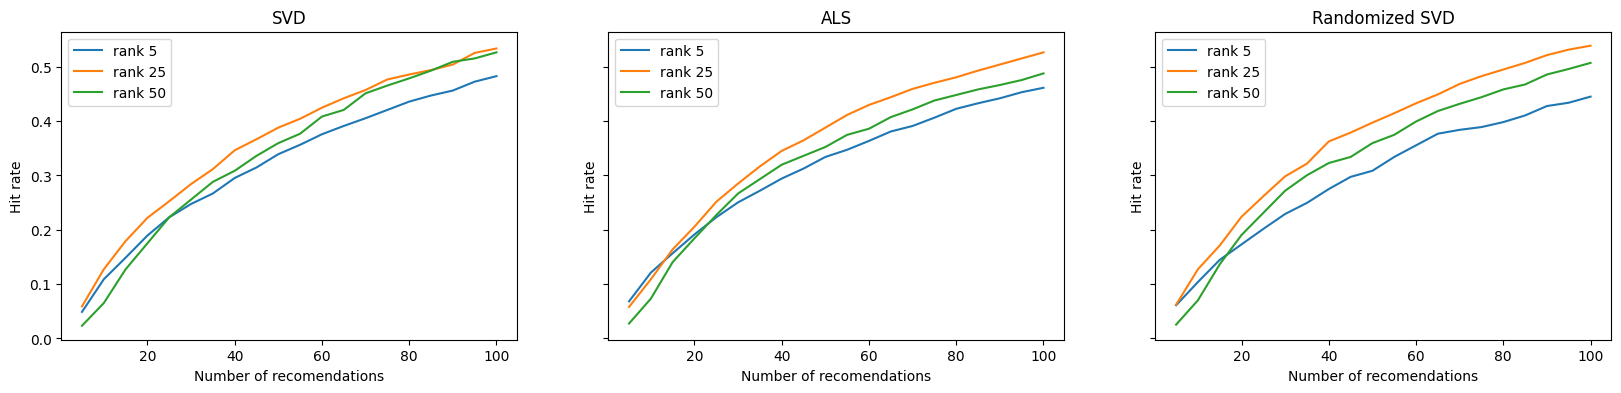

In [53]:
from scipy.sparse.linalg import svds

pred_ams = list(range(5, 101, 5))
ranks = [5, 25, 50]
_, (ax_svd, ax_als, ax_rand) = plt.subplots(1,3,figsize=(20, 4),sharey=True)
ax_svd.set_title("SVD")
ax_svd.set_ylabel("Hit rate")
ax_als.set_title("ALS")
ax_als.set_ylabel("Hit rate")
ax_rand.set_title("Randomized SVD")
ax_rand.set_ylabel("Hit rate")
for rank in ranks:
    _, _, VT_svd = svds(A_train, k=rank)
    _, VT_als, _, _, _ = ALS(A_train, rank)
    _, _, VT_rand = randomized_svd(A_train, rank)
    for VT, ax in zip([VT_svd, VT_als, VT_rand], [ax_svd, ax_als, ax_rand]):
        ax.set_xlabel("Number of recomendations")
        hit_rates = get_hit_rates(A_test[:1000,:], pred_ams, VT.T)
        line, = ax.plot(pred_ams, hit_rates)
        line.set_label('rank {}'.format(rank))
        ax.legend()

Какой ранг приближения оказался оптимальным для нашей модели в случае каждого алгоритма?

**Во всех случаях ранг 25 оказался оптимальным. (видимо, 5 - слишком мало, 50 мб начинает переобучаться)**

## Бонус. Higher-order SVD (100 баллов)

**В бонусе разрешается использовать циклы только по размерности.**

1. (**20 баллов**) Напишите функцию ```tuck2full(G, Us)```, возвращающую полный тензор размера $n_1\times n_2 \times \ldots \times n_d$ по его разложению Таккера. Предусмотрите, чтобы функция работала и в случае, если в матрицах $U_1,U_2, \ldots, U_d$ строк меньше, чем столбцов. Вместо циклов используйте функцию ```np.einsum```.

In [41]:
def tuck2full(G, Us):
    """

    Input:
        G: d-dimensional numpy array - Tucker core of size (r1, r2, ..., rd)
        Us: tuple of 2D numpy arrays - Tucker factors of size (n1, r1), ..., (nd, rd)

    Output:
        A: d-dimensional numpy array of the size (n1, n2, ..., nd)
    """

    core = ''.join(chr(97 + i) for i in range(len(Us)))
    factors = ''.join(chr(97 + len(Us) + i) for i in range(len(Us)))
    operands = [f'{factors[i]}{core[i]}' for i in range(len(Us))]
    s = f'{core},{",".join(operands)}->{factors}'
    A = np.einsum(s, G, *Us, optimize = 'optimal')

    return A


Небольшая проверка на то, что делаю не чушь

In [ ]:
!pip install tensorly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
import tensorly

In [ ]:
print(A[0][0][0])

[1.         0.5        0.33333333 0.25       0.2        0.16666667
 0.14285714 0.125      0.11111111 0.1        0.09090909 0.08333333
 0.07692308 0.07142857 0.06666667 0.0625     0.05882353 0.05555556
 0.05263158 0.05       0.04761905 0.04545455 0.04347826 0.04166667
 0.04       0.03846154 0.03703704 0.03571429 0.03448276 0.03333333
 0.03225806 0.03125    0.03030303 0.02941176 0.02857143 0.02777778
 0.02702703 0.02631579 0.02564103 0.025      0.02439024 0.02380952
 0.02325581 0.02272727 0.02222222 0.02173913 0.0212766  0.02083333
 0.02040816 0.02       0.01960784 0.01923077 0.01886792 0.01851852
 0.01818182 0.01785714 0.01754386 0.01724138 0.01694915 0.01666667
 0.01639344 0.01612903 0.01587302 0.015625   0.01538462 0.01515152
 0.01492537 0.01470588 0.01449275 0.01428571 0.01408451 0.01388889
 0.01369863 0.01351351 0.01333333 0.01315789 0.01298701 0.01282051
 0.01265823 0.0125     0.01234568 0.01219512 0.01204819 0.01190476
 0.01176471 0.01162791 0.01149425 0.01136364 0.01123596 0.0111

In [ ]:
I, J, K, L = np.meshgrid(np.arange(25), np.arange(50), np.arange(75), np.arange(100), indexing='ij')
A = 1 / (I + J + K + L + 1)
G, Us = tensorly.decomposition.tucker(A, rank = None)

/usr/local/lib/python3.10/dist-packages/tensorly/decomposition/_tucker.py:156: Warning: No value given for 'rank'. The decomposition will preserve the original size.
  warnings.warn(message, Warning)


In [ ]:
print(tuck2full(G, Us)[0][0][0])

[1.         0.5        0.33333333 0.25       0.2        0.16666667
 0.14285714 0.125      0.11111111 0.1        0.09090909 0.08333333
 0.07692308 0.07142857 0.06666667 0.0625     0.05882353 0.05555556
 0.05263158 0.05       0.04761905 0.04545455 0.04347826 0.04166667
 0.04       0.03846154 0.03703704 0.03571429 0.03448276 0.03333333
 0.03225806 0.03125    0.03030303 0.02941176 0.02857143 0.02777778
 0.02702703 0.02631579 0.02564103 0.025      0.02439024 0.02380952
 0.02325581 0.02272727 0.02222222 0.02173913 0.0212766  0.02083333
 0.02040816 0.02       0.01960784 0.01923077 0.01886792 0.01851852
 0.01818182 0.01785714 0.01754386 0.01724138 0.01694915 0.01666667
 0.01639344 0.01612903 0.01587302 0.015625   0.01538462 0.01515152
 0.01492537 0.01470588 0.01449275 0.01428571 0.01408451 0.01388889
 0.01369863 0.01351351 0.01333333 0.01315789 0.01298701 0.01282051
 0.01265823 0.0125     0.01234568 0.01219512 0.01204819 0.01190476
 0.01176471 0.01162791 0.01149425 0.01136364 0.01123596 0.0111

2. (**35 баллов**) Реализуйте higher-order SVD алгоритм для нахождения разложения Таккера данного $d$-мерного массива $A\in\mathbb{R}^{n_1\times \ldots \times n_d}$. Алгоритм должен находить малоранговое приближение $A$ с относительной точностью не хуже $\varepsilon$ во Фробениусовой норме. Функция должна вернуть ядро и факторы Таккера у приближающего тензора. Для получения ядра Таккера будет удобно воспользоваться функцией ```tuck2full```.

In [77]:
def hosvd(A, eps):
    """
        Input
            A: 3D numpy array
            eps: accuracy of Tucker approximation

        Output
            G: d-dimensional numpy array - Tucker core of size (r1, r2, ..., rd)
            Us: tuple of 2D numpy arrays - Tucker factors of size (n1, r1), ..., (nd, rd)
    """
    Us = []
    core = A.copy()
    for k in range(len(A.shape)):
        A_k = np.reshape(np.moveaxis(A, k, 0), (A.shape[k], -1))
        U, s, Vt = np.linalg.svd(A_k, full_matrices=False)
        rank_k = np.sum(s / np.linalg.norm(s) > eps)
        U_k = U[:, :rank_k]
        Us.append(U_k)
        core = np.tensordot(core, U_k.T, axes = (0, 1))

    return core, Us


3. (**5 баллов**) Примените функцию ```hosvd``` к тензору размера $25 \times 50 \times 75 \times 100$ с элементами
$$
    a_{ijkl} = \frac{1}{i + j + k + l + 1}, \quad i,j,k,l=0,1,...
$$
для малорангового приближения с точностью $10^{-6}$. Массив $A$ соберите с помощью функции ```np.meshgrid```. Напечатайте получившиеся ранги и относительную ошибку полученного малорангового приближения (для этого используйте функцию ```tuck2full```).

In [78]:
G, Us = hosvd(A, 1e-6)
A_approx = tuck2full(G, Us)
error = np.linalg.norm(A - A_approx) / np.linalg.norm(A)

print("Ranks:")
for i, U in enumerate(Us):
    print(f"Rank {i+1}: {U.shape[1]}")
print(f"Error: {error}")



Ranks:
Rank 1: 8
Rank 2: 9
Rank 3: 9
Rank 4: 9
Error: 7.877377763554455e-07


4. (**15 баллов**) Докажите, что норма Фробениуса приближения HOSVD $A'$ совпадает с её ядром Таккера $G'$:

$$
  \|A'\|_F = \|G'\|_F
$$

Знаем, что приближение HOSVD A' может быть расписано как следующее разложение Таккера: $$
  A' = G' \times U_1 \times ... \times U_N, где U_i - унитарные матрицы. $$ Но также мы знаем, что фробениусова норма G (в т.ч. и ее обобщение на тензоры, тк мы можем просто векторизовать) унитарно-инвариантна, а ортогональные преобразования сохраняют скалярное произведение. Применив эти знания N - 1 раз к разложению, получим искомое

5. (**25 баллов**) Для заданного таккеровского разложения напишите функцию вычисления его нормы. Примените ее к разложению тензора размера 10000 x 10000 x 10000 со случайными Таккеровскими факторами и ядром мультилинейного ранга (10, 10, 10).

In [61]:
def gen_orthonormal_matrix(i, j):
    A = np.random.randn(i, j)
    U, _, _ = np.linalg.svd(A, full_matrices = False)
    return U


In [62]:
def generate_random_tucker(original_dimensions, core_dimensions):
    core_tensor = np.random.rand(*core_dimensions)
    factor_matrices = [gen_orthonormal_matrix(original_dim, core_dim) for original_dim, core_dim in zip(original_dimensions, core_dimensions)]
    return core_tensor, factor_matrices

In [58]:

def tuck_norm(G, Us):
    """
        Input
            G: d-dimensional numpy array - Tucker core of size (r1, r2, ..., rd)
            Us: tuple of 2D numpy arrays - Tucker factors of size (n1, r1), ..., (nd, rd)

        Output
            norm: Frobenius norm of A = [G; U1 ... Ud]
    """
    return np.linalg.norm(G)

G, Us = generate_random_tucker([10000, 10000, 10000], [10, 10, 10])
frob = tuck_norm(G, Us)
print("Frobenius norm", frob)


Frobenius norm 17.809126236215885
